In [16]:
import os
import glob
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from ast import literal_eval

In [2]:
torch.cuda.set_device(1) 

In [3]:
RMSD_THRESHOLD_1 = 0.5
RMSD_THRESHOLD_2 = 2.0
RMSD_THRESHOLD = 1.0


In [6]:
class MulticlassDataset500(Dataset):
    def __init__(self, pt_file, label_csv, transform=None):
        self.features = torch.load(pt_file)
        self.labels = pd.read_csv(label_csv)
        self.labels = self.labels.drop(columns=['Unnamed: 0'])
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        if self.labels.loc[idx, 'rmsd'] < RMSD_THRESHOLD_1:
            label = 0
        elif self.labels.loc[idx, 'rmsd'] < RMSD_THRESHOLD_2:
            label = 1
        else:
            label = 2

        if self.transform:
            features = self.transform(features)
        return features, label

In [4]:
class SmallDataset500(Dataset):
    def __init__(self, pt_file, label_csv, transform=None):
        self.features = torch.load(pt_file)
        self.labels = pd.read_csv(label_csv)
        self.labels = self.labels.drop(columns=['Unnamed: 0'])
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        label = int(self.labels.loc[idx, 'rmsd'] >= RMSD_THRESHOLD)
        if self.transform:
            features = self.transform(features)
        return features, label

In [5]:
dataset = SmallDataset500(pt_file='../data/500_protein_dataset/500_protein_tensor.pt', label_csv='../data/500_protein_dataset/500_protein_labels.csv')

In [6]:
# Test some of the data
for i in range(20):
    feature, label = dataset[i]
    print(feature.shape, label)

torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0


## The following code is written by copilot

In [7]:
# Split the dataset into train and test sets.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [8]:
# Test the split
print(len(train_dataset), len(test_dataset))

90240 22561


In [9]:
# Create the dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Test the dataloaders
for i, (features, labels) in enumerate(train_loader):
    print(features.shape, labels.shape)
    break

torch.Size([128, 768]) torch.Size([128])


In [10]:
input_size = 768

# Define a binary classifier with five hidden layers
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, training=False):
        x = x.view(-1, 768)
        x = self.relu(self.fc1(x))
        if training:
            x = self.dropout(x)
        x = self.relu(self.fc2(x))
        if training:
            x = self.dropout(x)
        x = self.relu(self.fc3(x))
        if training:
            x = self.dropout(x)
        x = self.relu(self.fc4(x))
        if training:
            x = self.dropout(x)
        x = self.fc5(x)
        return x

In [11]:

model = SimpleClassifier()
model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
n_epochs = 30
for epoch in range(n_epochs):
    train_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(features, training=False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 0.279776
Epoch: 2 	Training Loss: 0.246970
Epoch: 3 	Training Loss: 0.233908
Epoch: 4 	Training Loss: 0.217473
Epoch: 5 	Training Loss: 0.195257
Epoch: 6 	Training Loss: 0.168841
Epoch: 7 	Training Loss: 0.142145
Epoch: 8 	Training Loss: 0.115974
Epoch: 9 	Training Loss: 0.093554
Epoch: 10 	Training Loss: 0.075881
Epoch: 11 	Training Loss: 0.058817
Epoch: 12 	Training Loss: 0.049516
Epoch: 13 	Training Loss: 0.040725
Epoch: 14 	Training Loss: 0.035845
Epoch: 15 	Training Loss: 0.031655
Epoch: 16 	Training Loss: 0.027694
Epoch: 17 	Training Loss: 0.026485
Epoch: 18 	Training Loss: 0.023152
Epoch: 19 	Training Loss: 0.020833
Epoch: 20 	Training Loss: 0.020551
Epoch: 21 	Training Loss: 0.019872
Epoch: 22 	Training Loss: 0.019315
Epoch: 23 	Training Loss: 0.016613
Epoch: 24 	Training Loss: 0.015665
Epoch: 25 	Training Loss: 0.017485
Epoch: 26 	Training Loss: 0.014716
Epoch: 27 	Training Loss: 0.013977
Epoch: 28 	Training Loss: 0.016438
Epoch: 29 	Training Loss: 0.0

In [12]:
# Test the accuracy of the model on the train set
correct = 0
total = 0
with torch.no_grad():
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Train set accuracy:   %d %%' % (100 * correct / total))

# Test the accuracy, precision, recall and F1 score of the model
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        for j in range(len(labels)):
            if labels[j] == 0 and predicted[j] == 0:
                true_negative += 1
            elif labels[j] == 1 and predicted[j] == 0:
                false_negative += 1
            elif labels[j] == 1 and predicted[j] == 1:
                true_positive += 1
            elif labels[j] == 0 and predicted[j] == 1:
                false_positive += 1

print('Test set accuracy:    %d %%' % (100 * (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)))
print('Test set precision:   %d %%' % (100 * true_positive / (true_positive + false_positive)))
print('Test set recall:      %d %%' % (100 * true_positive / (true_positive + false_negative)))
print('Test set F1 score     %d %%' % (100 * 2 * true_positive / (2 * true_positive + false_positive + false_negative)))

Train set accuracy:   99 %
Test set accuracy:    91 %
Test set precision:   46 %
Test set recall:      30 %
Test set F1 score     37 %


In [13]:
class SmallDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file).sample(500)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        embedding_path = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        embedding = torch.load(embedding_path)[0,0,1:,:]
        label = literal_eval(self.labels.iloc[idx, 1])
        if self.transform:
            embedding = self.transform(embedding)
        return embedding, label, embedding_path
    
dataset_orig = SmallDataset(csv_file='../data/rmsd_dataset.csv',
                                    root_dir='/mnt/nasdata/vera/msa_transformer_embeddings/')

In [55]:
print(paths)

['/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_2ela_b.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_4jam_h.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_3ab1_b.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_4p4r_b.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_5xcn_x.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_3tri_a.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_4qvg_c.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_5o85_d.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_1zl0_a.pt', '/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_4nuo_a.pt']


In [58]:
dataset_orig[1][2]

'/mnt/nasdata/vera/msa_transformer_embeddings/embeddings_3aqo_c.pt'

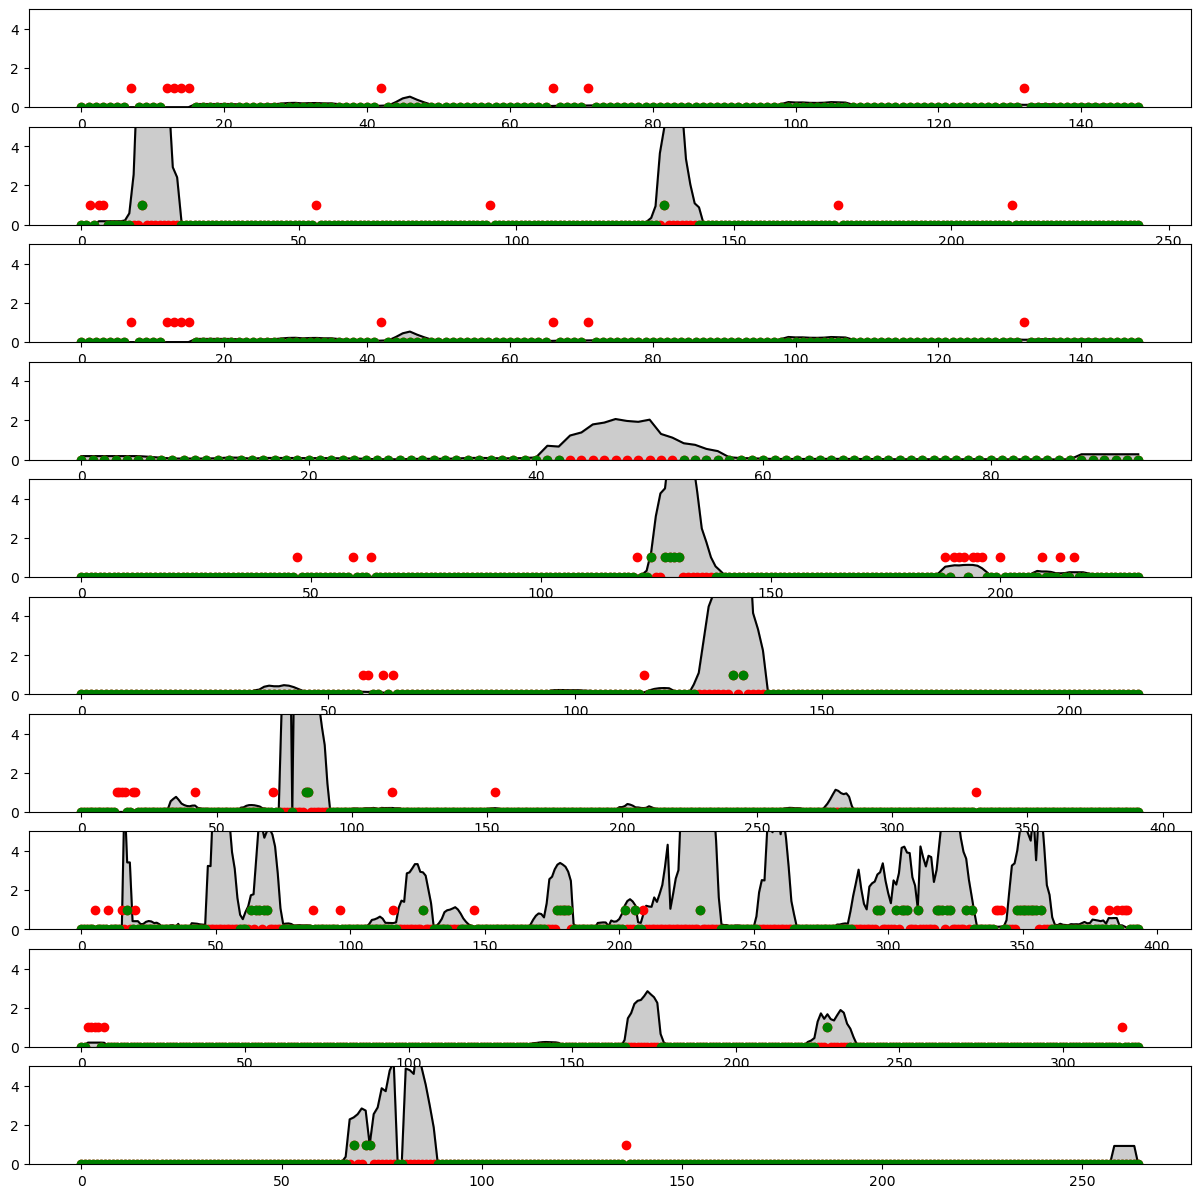

In [18]:

fig = plt.figure(figsize=(15, 15))

for i in range(10):
    # Add subplot vertically
    ax = fig.add_subplot(10, 1, i+1)

    # Test for a single protein
    test_protein = dataset_orig[random.randint(0, len(dataset_orig))]

    # Get the predicted labels for each residue
    predicted_labels = []
    with torch.no_grad():
        for residue in test_protein[0]:
            #residue = torch.tensor(residue).cuda()
            #residue = residue.view(1, 1, 768)
            output = model(residue)
            _, predicted = torch.max(output.data, 1)
            predicted_labels.append(predicted.item())

    # Get the actual labels for each residue
    actual_labels = []
    correct_labels = []
    for residue in test_protein[1]:
        actual_labels.append(residue)
        correct_labels.append(int(residue >= RMSD_THRESHOLD))

    # Get a list of correctly predicted labels
    correctly_predicted_labels = []
    for i in range(len(predicted_labels)):
        if correct_labels[i] == 1 and predicted_labels[i] == RMSD_THRESHOLD:
            correctly_predicted_labels.append(RMSD_THRESHOLD)
        elif correct_labels[i] == 0 and predicted_labels[i] == 0:
            correctly_predicted_labels.append(0)
        else:
            correctly_predicted_labels.append(None)

    # Plot the actual labels as black
    ax.plot(actual_labels, color='black')
    ax.plot(predicted_labels, color='red', marker='o', linestyle='None')
    ax.plot(correctly_predicted_labels, color='green', marker='o', linestyle='None')
    ax.set_ylim(0, RMSD_THRESHOLD*5)
    # Fill under the curve in a rainbow gradient
    ax.fill_between(range(len(actual_labels)), actual_labels, color='black', alpha=0.2)

plt.show()


    

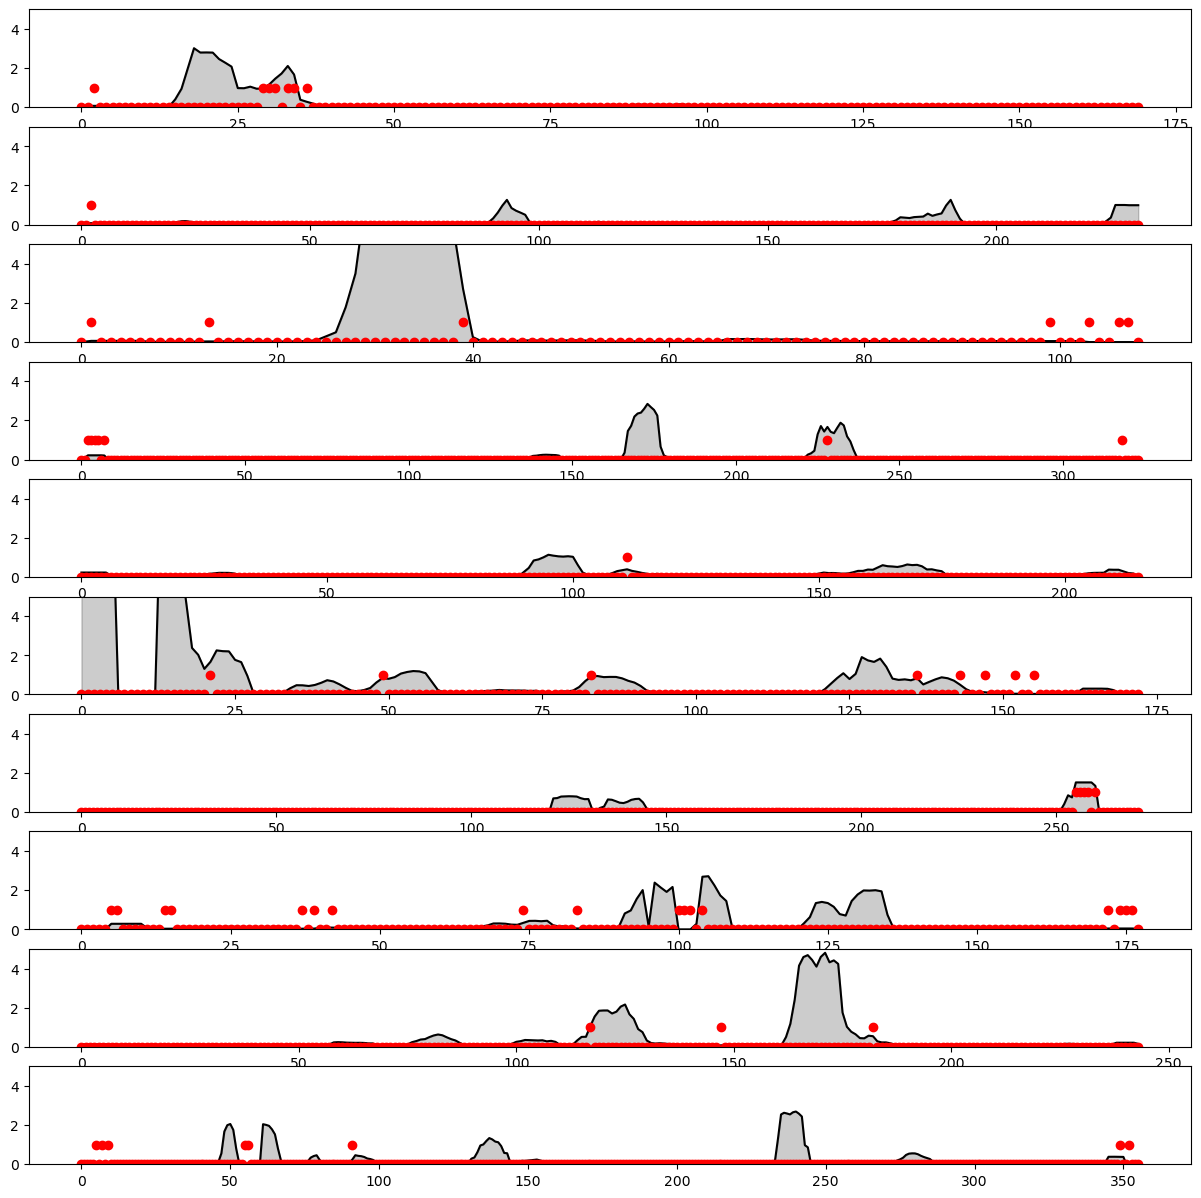

In [17]:

fig = plt.figure(figsize=(15, 15))

for i in range(10):
    # Add subplot vertically
    ax = fig.add_subplot(10, 1, i+1)

    # Test for a single protein
    test_protein = dataset_orig[random.randint(0, len(dataset_orig))]

    # Get the predicted labels for each residue
    predicted_labels = []
    with torch.no_grad():
        for residue in test_protein[0]:
            #residue = torch.tensor(residue).cuda()
            #residue = residue.view(1, 1, 768)
            output = model(residue)
            _, predicted = torch.max(output.data, 1)
            predicted_labels.append(predicted.cpu().numpy()[0]*RMSD_THRESHOLD)

    # Get the actual labels for each residue
    actual_labels = []
    correct_labels = []
    for residue in test_protein[1]:
        actual_labels.append(residue)
        correct_labels.append(int(residue >= RMSD_THRESHOLD))

    # Get a list of correctly predicted labels
    correctly_predicted_labels = []
    for i in range(len(predicted_labels)):
        if correct_labels[i] == 1 and predicted_labels[i] == RMSD_THRESHOLD:
            correctly_predicted_labels.append(RMSD_THRESHOLD)
        elif correct_labels[i] == 0 and predicted_labels[i] == 0:
            correctly_predicted_labels.append(0)
        else:
            correctly_predicted_labels.append(None)

    # Plot the actual labels as black
    ax.plot(actual_labels, color='black')
    ax.plot(predicted_labels, color='red', marker='o', linestyle='None')
    #ax.plot(correctly_predicted_labels, color='green', marker='o', linestyle='None')
    ax.set_ylim(0, RMSD_THRESHOLD*5)
    # Fill under the curve in a rainbow gradient
    ax.fill_between(range(len(actual_labels)), actual_labels, color='black', alpha=0.2)

plt.show()


    